# Linear BMM with full Bayesian calibration of coleman toy models

The models can be found in Coleman Thesis : https://go.exlibris.link/3fVZCfhl

This notebook shows how to use the Bayesian model mixing package **Taweret** for a toy problem. 

Author : Dan Liyanage 

Date : 19/21/2022

## Steps for linear BMM
    1. Get Models with a prediction method
    2. Choose a Mixing method 
    3. Estimate the mixture weights (parameters in the mixture function) with user defined calibration method
To execute each step in this notebook we need to import the following from Taweret.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../../../Taweret'))


In [2]:
# Import models with a predict method
from Taweret.models import coleman_models as toy_models
# Mixing object with a likelihood method
from Taweret.mix.linear import linear_mix as LM
# Wrapper for the likelihood to be used with Bilby
from Taweret.calibrate.likelihood_wrappers import likelihood_wrapper_for_bilby 

In [3]:
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For calibration
import bilby

# For other operations
import numpy as np
import os
import shutil

In [4]:
m1 = toy_models.coleman_model_1()
m2 = toy_models.coleman_model_2()
truth = toy_models.coleman_truth()

In [5]:
g = np.linspace(-1,9,10)
plot_g = np.linspace(-1,9,100)
true_output = truth.predict(plot_g)
exp_data = truth.predict(g)

# 1. The models and the experimental data.

Truth
 
$f(x) = 2-0.1(x-4)^2$, where $x \in [-1, 9]$

Model 1

$f_1(x,\theta)= 0.5(x+\theta)-2$    , where $\theta \in [1, 6]$

Model 2

$f_2(x,\theta)= -0.5(x-\theta) + 3.7$   , where $\theta \in [-2, 3]$

Experimental data 

sampled from the Truth with a fixed standard deviation of 0.3




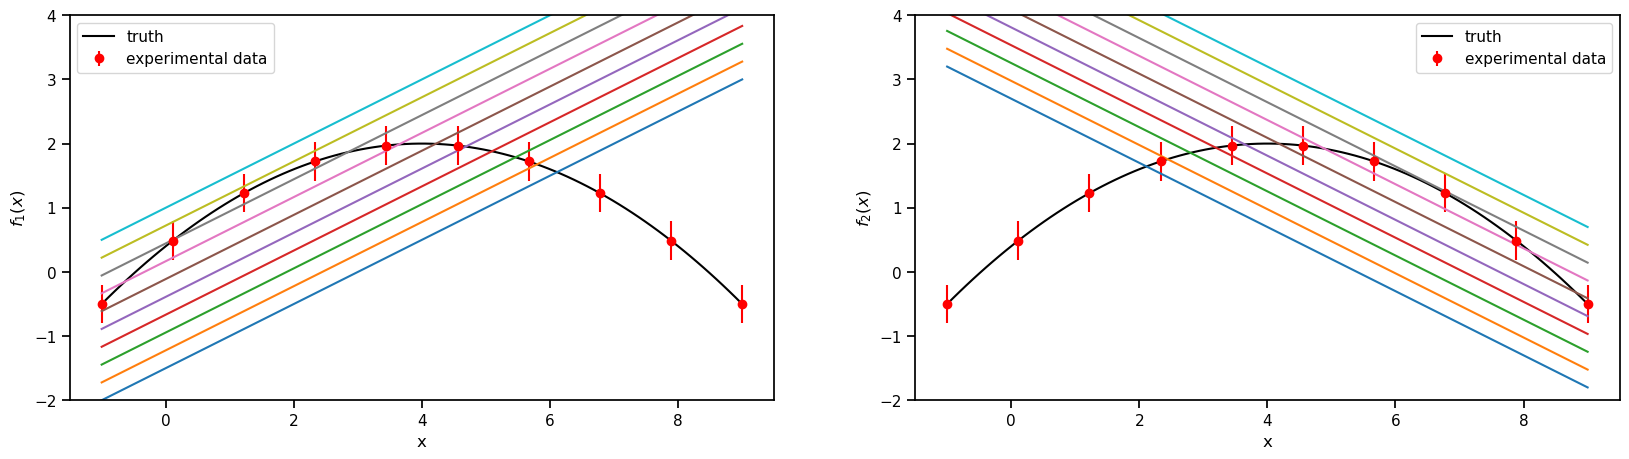

In [6]:
sns.set_context('notebook')
fig, axs = plt.subplots(1,2,figsize=(20,5))
prior_ranges = [(1,6), (-2,3)]
for i in range(0,2):
    ax = axs.flatten()[i]
    ax.plot(plot_g, true_output[0], label='truth', color='black')
    ax.errorbar(g,exp_data[0],exp_data[1], fmt='o', label='experimental data', color='r')
    ax.legend()
    ax.set_ylim(-2,4)
    for value in np.linspace(*prior_ranges[i],10):
        if i==0:
            predict_1 = m1.predict(plot_g, value)
            ax.plot(plot_g, predict_1[0])
            ax.set_ylabel(r'$f_1(x)$')
        if i==1:
            predict_2 = m2.predict(plot_g, value)
            ax.plot(plot_g, predict_2[0])      
            ax.set_ylabel(r'$f_2(x)$')    
    ax.set_xlabel('x') 
    


#  2. Choose a Mixing method

In [7]:
mix_model = LM(m1, m2, g, exp_data[0], exp_data[1], method='cdf', n_model_1=1, n_model_2=1, n_mix=2)

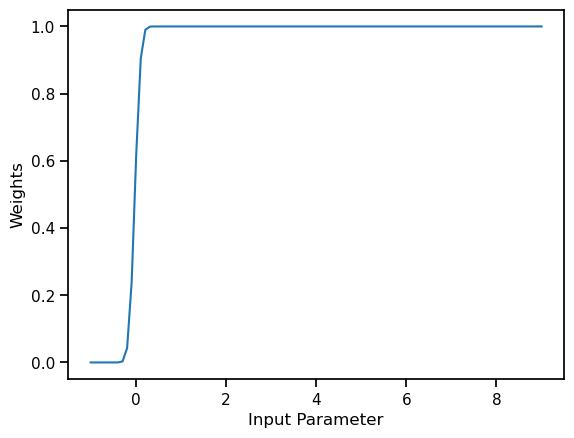

In [8]:
mix_model.plot_weights(np.array([0.2, 10]),plot_g)

In [9]:
#mix_model.mix_loglikelihood_test([0.25])

In [10]:
mix_model.mix_loglikelihood(np.array([0.2, 10]), np.array([2]),np.array([1]))

0.2897570171611727

### BMM model output corresponding to the above input weights 

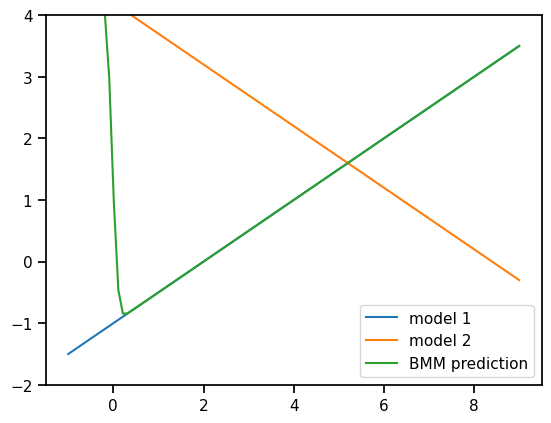

In [11]:
fig, ax = plt.subplots()
mix_prediction = mix_model.prediction(np.array([0.2, 10]), plot_g, np.array([2]), np.array([1]))
ax.plot(plot_g, m1.predict(plot_g, np.array([2]))[0].flatten(), label='model 1')
ax.plot(plot_g, m2.predict(plot_g, np.array([1]))[0].flatten(), label='model 2')
ax.plot(plot_g, mix_prediction.flatten(), label='BMM prediction')
ax.set_ylim(-2,4)
ax.legend()

### Log likelihood of the mixed model as a function of the Step mixing function parameter

In [12]:
# sw = np.linspace(0.01,1,1000)
# likelihood = np.array([mix_model.mix_loglikelihood([s]) for s in sw]).flatten()
# fig, ax = plt.subplots()
# ax.plot(sw,likelihood,label='Mixture likelihood for step function')

# 3. Estimating the mixture weights

### Wrap the likelihood function in the mixed model to be calibrated

In [13]:
likelihood = likelihood_wrapper_for_bilby(mix_model)

### Get posterior samples using Bilby

- Here theta_0, theta_1 are CDF mixture function parameters
- theta_2 is the model_1 parameter
- theta_3 is the model_2 parameter



In [14]:
# A few simple setup steps
label = "cdf_mixing"
outdir = "outdir"

priors = dict(theta_0=bilby.core.prior.Normal(0, 1, "theta_0"),
   theta_1=bilby.core.prior.Normal(0, 1, "theta_1"),
   theta_2=bilby.core.prior.Uniform(1, 6, "theta_2"),
   theta_3=bilby.core.prior.Uniform(-2, 3, "theta_3"))

# priors = dict(
#     theta_0=bilby.core.prior.Beta(2,2)
# )

# And run sampler
## If file exists, delete it ##
if os.path.exists(outdir):
    shutil.rmtree(outdir)
result = bilby.run_sampler(
    likelihood,
    priors,
    sampler="ptemcee",
    ntemps=5,
    nwalkers=100,
    Tmax=10,
    nburn=200,
    nsamples=500,  # This is the number of raw samples
    threads=5,
    )
result.plot_corner()


23:26 bilby INFO    : Running for label 'label', output will be saved to 'outdir'


SamplerNotInstalledError: Sampler ptemcee is not installed on this system

In [ ]:
result.posterior['theta_0']

### trace plots

In [ ]:

#sns.set_context(font_scale=100)
for i in range(0,4):
    fig, ax = plt.subplots(figsize=(50,10))
    ax.plot(result.posterior[f'theta_{i}'].values)

In [ ]:
pos_weight_func = []
for sample in result.posterior.values[:,0:2]:
    
    mean = mix_model.weights(np.array([sample]).flatten(), plot_g)
    pos_weight_func.append(mean)
pos_weight_func = np.array(pos_weight_func).reshape(-1,len(plot_g))

In [ ]:
per0,per5,per20,per80,per95,per100=np.percentile(pos_weight_func,[0,5,20,80,95,100], axis=0)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.fill_between(plot_g,per5,per95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,per20,per80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.legend()
#ax.plot(plot_g, true_output[0], label='truth')
#ax.set_ylim(1.2,3.2)

### Predictions for the mixed model with posterior weights

In [ ]:
result.posterior

In [ ]:
pos_predictions = []
for sample in result.posterior.values:
    sample = np.array(sample).flatten()
    mean = mix_model.prediction(sample[0:2],plot_g, sample[2], sample[3])
    pos_predictions.append(mean)
pos_predictions = np.array(pos_predictions).reshape(-1,len(plot_g))

In [ ]:
pos_predictions.shape

In [ ]:
per0,per5,per20,per80,per95,per100=np.percentile(pos_predictions,[0,5,20,80,95,100], axis=0)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.fill_between(plot_g,per5,per95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,per20,per80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.plot(plot_g, true_output[0], label='truth')
ax.legend()
ax.set_ylim(-2,4)